# Test PETSc solvers

Set up a simple regularly-spaced Cartesian domain to decompose and hand off to other processors.

Available PETSc objects include:

- **Matrix** - takes I, J, V vectors and the global shape
- **Vector** - takes RHS vector and the global length of the vector
- **Solver** - takes a preconditioner type and a Krylov Space Method, otherwise it just uses the default GMRES solver

All PETSc objects require an MPI communicator object, `comm`, for parallel operations.

Before we proceed, make sure `petsc4py` is installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from badlands import petsc as solvers
from mpi4py import MPI
comm = MPI.COMM_WORLD

%matplotlib inline

In [2]:
class HotBox:
    """
    Simple conduction example with Dirichlet boundary conditions
    """
    def __init__(self, nx, ny, kappa, H):
        
        self.kappa = np.asarray(kappa, dtype='f')
        self.H = np.asarray(H, dtype='f')
        
        nodes = np.arange(nx*ny).reshape(ny,nx)
        n = nx*ny
        self.nx, self.ny = nx, ny
        self.dx, self.dy = 1., 1.
        
        # boundary nodes
        self.top_nodes = nodes[0,:]
        self.bottom_nodes = nodes[-1,:]
        self.left_nodes = nodes[1:-1,0]
        self.right_nodes = nodes[1:-1,-1]
        
        # Mask boundary
        bmask = np.zeros_like(nodes, dtype=bool)
        bmask[1:-1,1:-1] = True
        self.nodes = nodes[bmask].flatten()

        # Sparse IJV vectors
        self.I = np.zeros(n*5, dtype=int)
        self.J = np.zeros(n*5, dtype=int)
        self.V = np.zeros(n*5)
        
        # RHS matrix
        self.RHS = np.zeros(n)
        
    def sle(self, bc=[0., 1., 0., 1.]):
        """
        Return a system of linear equation and a RHS vector
        """
        self.nPos = 0
        
        # Boundaries
        for i, idx in enumerate([self.top_nodes, self.right_nodes, self.bottom_nodes, self.left_nodes]):
            for index in idx:
                self.write_matrix(index, index, 1.0)
                self.RHS[index] = bc[i]
        
        # Main finite differences setup
        for idx in self.nodes:
            self.write_matrix(idx, idx-self.nx, self.kappa/self.dy**2)
            self.write_matrix(idx, idx-1, self.kappa/self.dx**2)
            self.write_matrix(idx, idx, -2.*self.kappa/self.dx**2 - 2.*self.kappa/self.dy**2)
            self.write_matrix(idx, idx+1, self.kappa/self.dx**2)
            self.write_matrix(idx, idx+self.nx, self.kappa/self.dy**2)
            
            self.RHS[idx] = -self.H
        
        return self.I, self.J, self.V, self.RHS
        
    def write_matrix(self, I, J, V):
        self.I[self.nPos] = I
        self.J[self.nPos] = J
        self.V[self.nPos] = V
        self.nPos += 1


## Single processor

Lets make sure we can solve a system of linear equations using just one processor.

In the first part we confirm the accuracy of solutions, then we run some timing benchmarks.

In [3]:
# Set up aij vectors for sparse matrix operations

nx, ny = 50, 50
n = nx*ny

box = HotBox(nx, ny, 1.0, 2e-6)
I, J, V, rhs = box.sle()

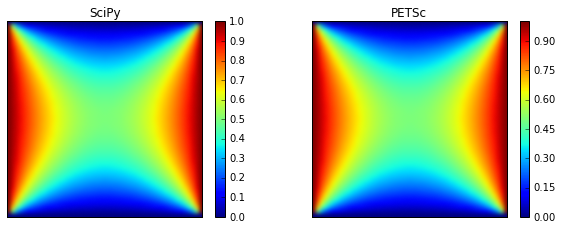

Maximum difference between solutions: 0.000124128832269


In [4]:
A_scipy = sparse.coo_matrix((V, (I, J)))
b_scipy = rhs
X_scipy = spsolve(A_scipy.tocsc(), b_scipy) # solution

A_petsc = solvers.Matrix(I, J, V, shape=(n,n), comm=comm)
b_petsc = solvers.Vector(rhs, rhs.size, comm=comm)
X_petsc = solvers.solve(A_petsc, b_petsc) # solution

# Plot solution
fig = plt.figure(1, figsize=(10,3.5))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(X_scipy.reshape(ny,nx), interpolation='bicubic')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('SciPy')
fig.colorbar(im1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(X_petsc.reshape(ny,nx), interpolation='bicubic')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('PETSc')
fig.colorbar(im2)

plt.show()
print "Maximum difference between solutions:", np.abs(X_scipy - X_petsc).max()

In [5]:
# Matrix operations

A2_scipy = (A_scipy + A_scipy).toarray()
A2_petsc = (A_petsc + A_petsc).toarray()
print "element-wise addition", (A2_scipy == A2_petsc).all()


AA_scipy = (A_scipy * A_scipy).toarray()
AA_petsc = (A_petsc * A_petsc).toarray()
print "matrix-matrix multiplication", (AA_scipy == AA_petsc).all()


Ab_scipy = A_scipy * b_scipy
Ab_petsc = A_petsc * b_petsc
print "matrix-vector multiplication", (Ab_scipy == Ab_petsc).all()

element-wise addition True
matrix-matrix multiplication True
matrix-vector multiplication True


### Timings

Let's find out how SciPy and PETSc compare for solves and arithmetic operations.

In [7]:
import time
nx, ny = 500, 500
n = nx*ny

box = HotBox(nx, ny, 1.0, 2e-6)
I, J, V, rhs = box.sle()

t1 = time.clock()
A_scipy = sparse.coo_matrix((V, (I, J))).tocsr()
b_scipy = rhs
t2 = time.clock()
A_petsc = solvers.Matrix(I, J, V, shape=(n,n), comm=comm)
b_petsc = solvers.Vector(rhs, rhs.size, comm=comm)
t3 = time.clock()
print "Construction time... SciPy:", t2-t1, "PETSc:", t3-t2

Construction time... SciPy: 0.054566 PETSc: 0.484779


In [8]:
t1 = time.clock()
AA_scipy = A_scipy * A_scipy
t2 = time.clock()
AA_petsc = A_petsc * A_petsc
t3 = time.clock()
print "Matrix multiplication time... SciPy:", t2-t1, "PETSc:", t3-t2

Matrix multiplication time... SciPy: 0.083671 PETSc: 0.818095


In [9]:
t1 = time.clock()
Ab_scipy = A_scipy * b_scipy
t2 = time.clock()
Ab_petsc = A_petsc * b_petsc
t3 = time.clock()
print "Matrix-Vector multiplication time... SciPy:", t2-t1, "PETSc:", t3-t2

Matrix-Vector multiplication time... SciPy: 0.007406 PETSc: 0.015546


In [10]:
t1 = time.clock()
A_scipy + A_scipy
t2 = time.clock()
A_petsc + A_petsc
t3 = time.clock()
print "Matrix addition time... SciPy:", t2-t1, "PETSc:", t3-t2

Matrix addition time... SciPy: 0.015325 PETSc: 1.866655


In [12]:
t1 = time.clock()
spsolve(A_scipy, rhs)
t2 = time.clock()
solvers.solve(A_petsc, b_petsc, ksp='lu')
t3 = time.clock()
print "Solving time... SciPy:", t2-t1, "PETSc:", t3-t2

Solving time... SciPy: 11.022898 PETSc: 37.907333


## Multiple processors

Now we can move onto solving a SLE across multiple processors.

We want a parallel environment, so run the following command in a shell...

You will get a list of available options to benchmark PETSc using the `HeatBox` class defined earlier.